In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib



In [40]:
df = pd.read_csv("../data/emails.csv")
df.sample(frac=1)


,email_text,category
390,What's the process for medical insurance claim?,HR
303,The annual company day is coming up! Block you...,Other
312,I'm reaching out to inquire about the reimburs...,HR
812,Can I update my bank details?,HR
153,"Dear Team,\n\nI have forgotten my Absher usern...",IT
...,...,...
598,Canâ€™t log in to my corporate email.,IT
122,"Hi, We are in need of a mobile device manageme...",IT
711,Please help me install Python 3.10. I donâ€™t ...,IT
795,I need access to the testing server for our ne...,IT


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   email_text  902 non-null    object
 1   category    902 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [42]:
df["category"] = df["category"].replace({"Customer Service": "Other"})

# Remove null/empty rows
df.dropna(subset=["email_text", "category"], inplace=True)
df = df[df["email_text"].str.strip() != ""]

df["category"].value_counts()


category
IT       303
Other    301
HR       298
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Email Labels')

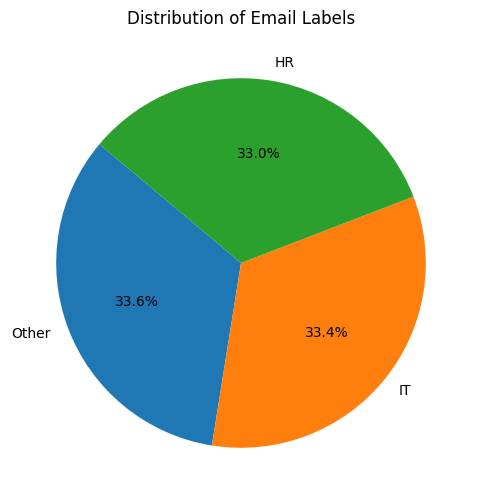

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
plt.pie(df['category'].value_counts(), labels=df['category'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Email Labels')


In [44]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text) # remove non-alphabet
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["email_text"].apply(clean_text)
df[["email_text", "clean_text", "category"]].head()


,email_text,clean_text,category
0,I am inquiring about the possibility of purch...,i am inquiring about the possibility of purcha...,Other
1,I recently made a purchase through the Giving ...,i recently made a purchase through the giving ...,Other
2,I placed an order through the website; however...,i placed an order through the website however ...,Other
3,Hello \nI received my order but I noticed that...,hello i received my order but i noticed that t...,Other
4,Good morning \nI am wondering if the discount ...,good morning i am wondering if the discount co...,Other


In [45]:
X = df["clean_text"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [46]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((721, 2593), (181, 2593))

In [47]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Optional: View mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)



Label Mapping: {'HR': np.int64(0), 'IT': np.int64(1), 'Other': np.int64(2)}


In [48]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_vec, y_train)

y_pred_lr = lr.predict(X_test_vec)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


LR Accuracy: 0.9281767955801105
              precision    recall  f1-score   support

          HR       0.92      0.98      0.95        60
          IT       0.92      0.93      0.93        61
       Other       0.95      0.87      0.90        60

    accuracy                           0.93       181
   macro avg       0.93      0.93      0.93       181
weighted avg       0.93      0.93      0.93       181



In [49]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec, y_train)

y_pred_rf = rf.predict(X_test_vec)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


RF Accuracy: 0.9502762430939227
              precision    recall  f1-score   support

          HR       0.98      0.98      0.98        60
          IT       0.92      0.95      0.94        61
       Other       0.95      0.92      0.93        60

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181



In [50]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_vec, y_train_enc)

y_pred_xgb = xgb.predict(X_test_vec)

# Decode predictions back to string labels for evaluation
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Now evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_labels))
print(classification_report(y_test, y_pred_xgb_labels))


c:\Users\gaura\AppData\Local\pypoetry\Cache\virtualenvs\smart-email-assistant-D3JU6J3z-py3.11\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9060773480662984
              precision    recall  f1-score   support

          HR       0.90      1.00      0.94        60
          IT       0.91      0.87      0.89        61
       Other       0.91      0.85      0.88        60

    accuracy                           0.91       181
   macro avg       0.91      0.91      0.90       181
weighted avg       0.91      0.91      0.90       181



In [51]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
y_pred_dt = dt.predict(X_test_vec)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.850828729281768
              precision    recall  f1-score   support

          HR       0.90      0.87      0.88        60
          IT       0.82      0.82      0.82        61
       Other       0.84      0.87      0.85        60

    accuracy                           0.85       181
   macro avg       0.85      0.85      0.85       181
weighted avg       0.85      0.85      0.85       181



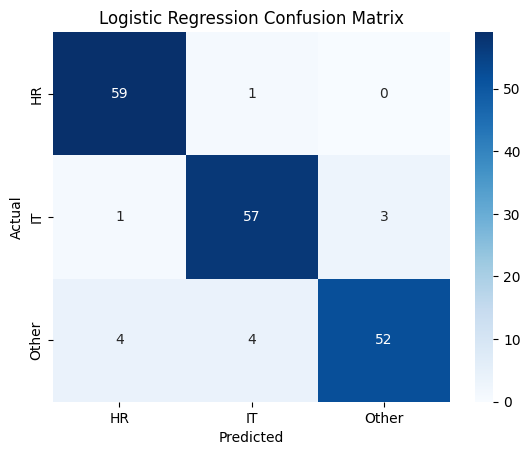

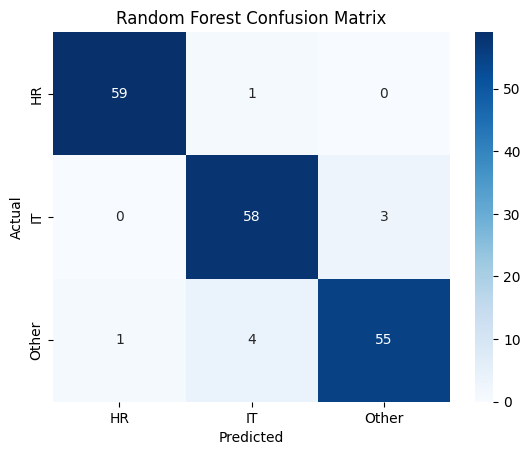

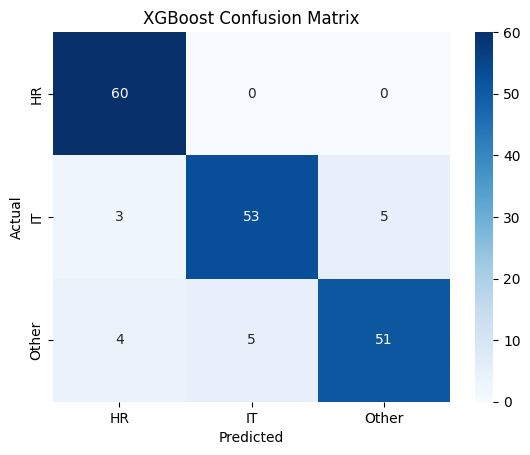

<Figure size 640x480 with 0 Axes>

In [56]:
def plot_confusion(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=["HR", "IT", "Other"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["HR", "IT", "Other"],
                yticklabels=["HR", "IT", "Other"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    plt.savefig(f"{model_name}_confusion_matrix.png")

plot_confusion("Logistic Regression", y_test, y_pred_lr)
plot_confusion("Random Forest", y_test, y_pred_rf)
plot_confusion("XGBoost", y_test, y_pred_xgb_labels)


In [53]:
joblib.dump(rf, "../models/model.pkl")
joblib.dump(vectorizer, "../models/vectorizer.pkl")
joblib.dump(label_encoder, "../models/label_encoder.pkl")

print("✅ Model, vectorizer, and label encoder saved!")

✅ Model, vectorizer, and label encoder saved!


### Since the Accuracy of LogisticRegression model is highest (0.93) we will continue with LogisticRegression 